The simulation below compares two optimization appraches and see which one is best fit to gerneate dataset. Those 2 approaches are:
- Gradient Descent
- Manifold

Research Paper : https://www.mdpi.com/2673-8732/2/3/25

Average Final SNRs (dB):
Transmit Power 0 dBm: GD = 65.82, Manifold = 60.06, Baseline = 47.19
Transmit Power 5 dBm: GD = 70.82, Manifold = 65.02, Baseline = 53.99
Transmit Power 10 dBm: GD = 75.84, Manifold = 69.88, Baseline = 58.31
Transmit Power 15 dBm: GD = 80.81, Manifold = 75.15, Baseline = 64.34
Transmit Power 20 dBm: GD = 85.81, Manifold = 79.99, Baseline = 69.27
Transmit Power 25 dBm: GD = 90.82, Manifold = 85.27, Baseline = 76.95
Transmit Power 30 dBm: GD = 95.80, Manifold = 90.27, Baseline = 76.81


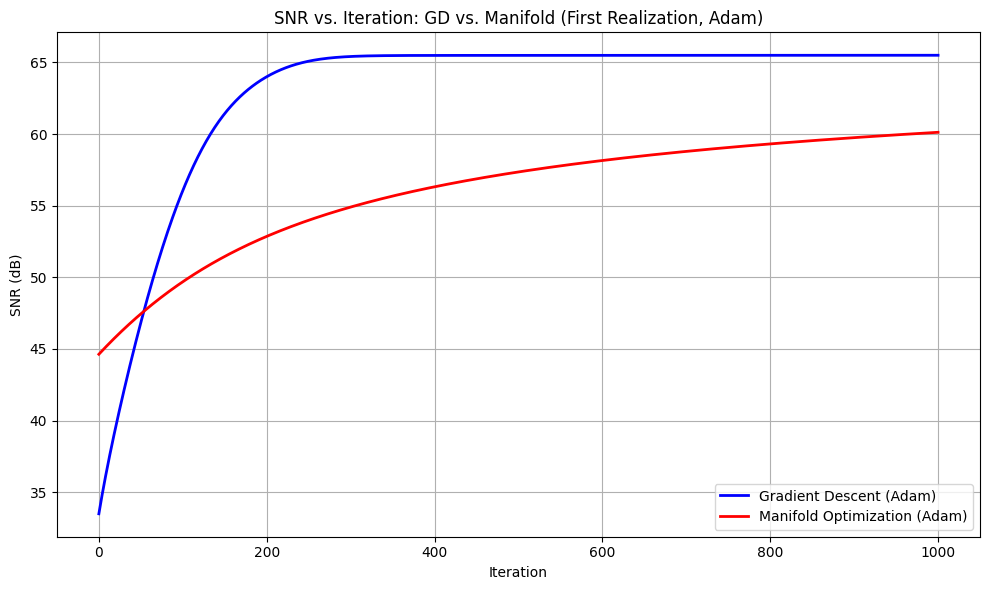

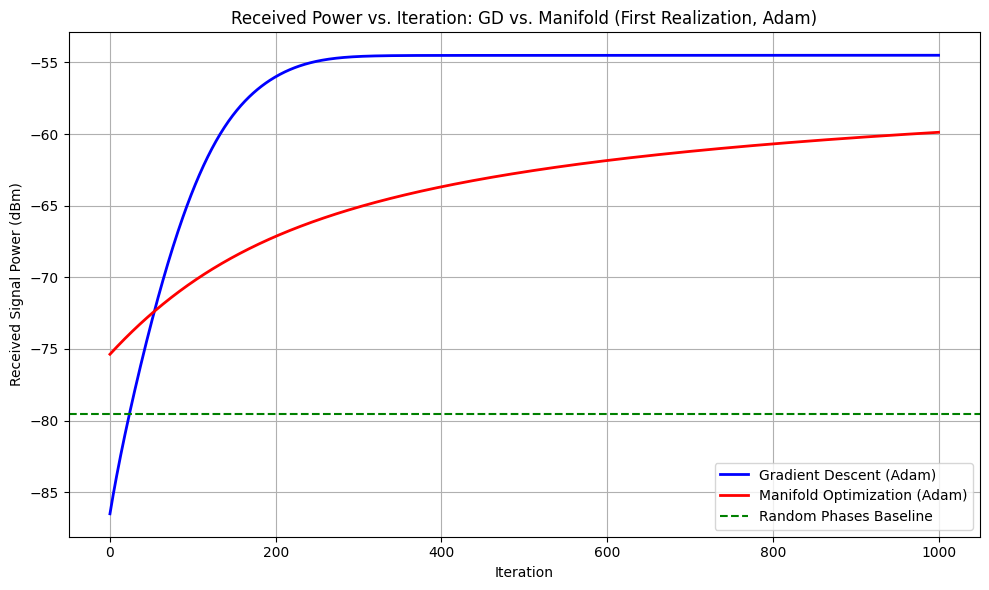

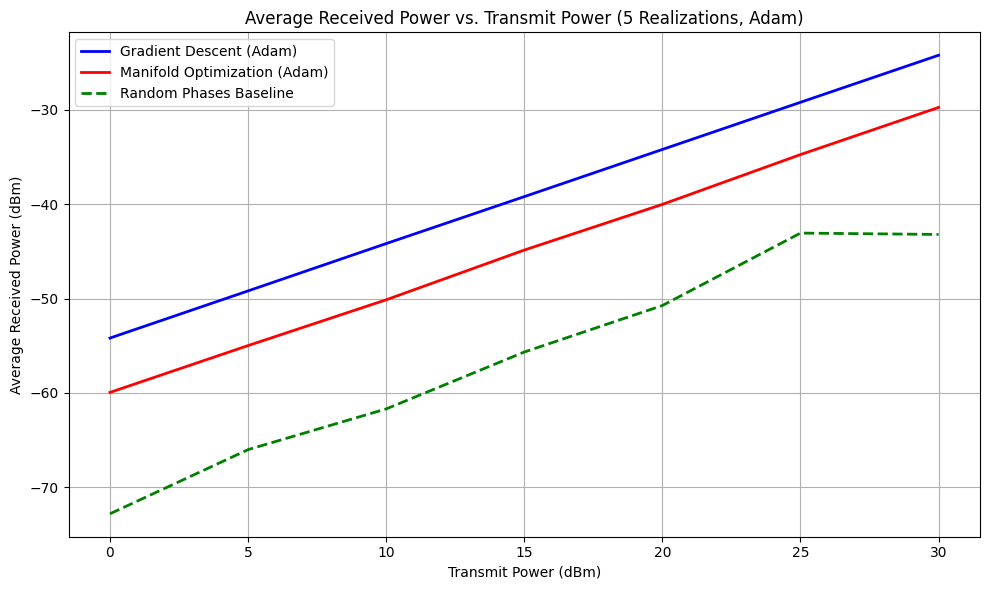

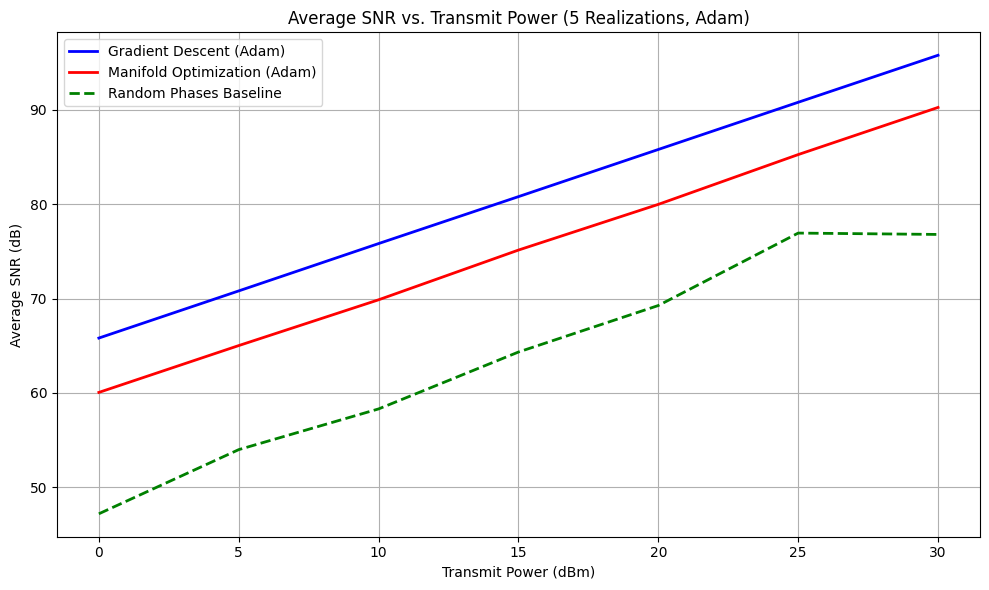

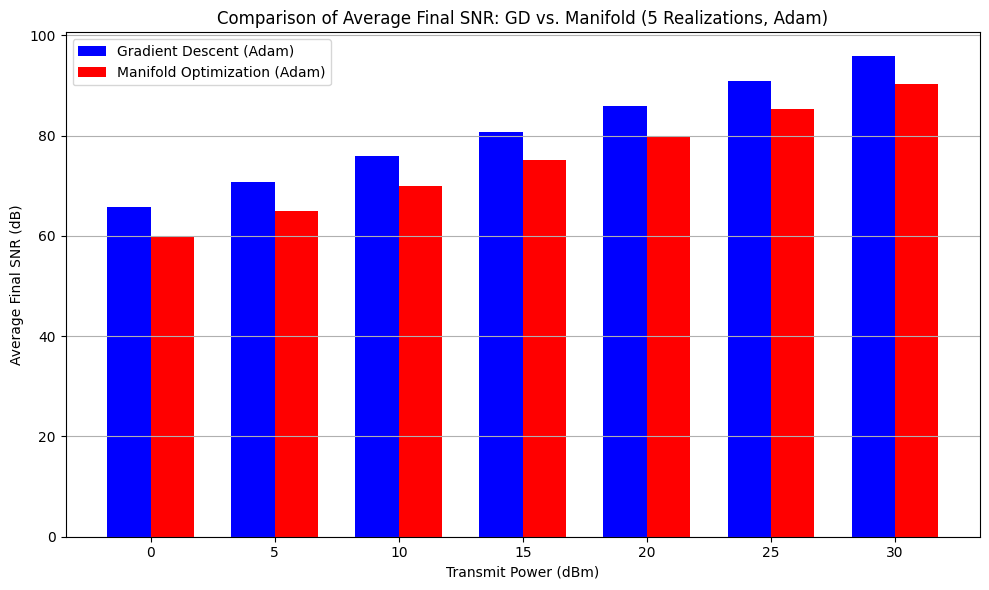

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Block 1: Channel Generation
def generate_rician_channel(shape, K_factor=10.0, path_loss_dB=-30.0):
    """
    Generate a Rician fading channel with path loss.
    
    Parameters:
    shape : tuple, shape of the channel array
    K_factor : float, Rician K-factor (LOS to NLOS power ratio)
    path_loss_dB : float, path loss in dB
    
    Returns:
    ndarray, Rician fading channel scaled by path loss
    """
    path_loss = 10 ** (path_loss_dB / 10)
    los = np.exp(1j * np.random.uniform(0, 2 * np.pi, shape))
    nlos = (np.random.randn(*shape) + 1j * np.random.randn(*shape)) / np.sqrt(2)
    channel = np.sqrt(K_factor / (K_factor + 1)) * los + np.sqrt(1 / (K_factor + 1)) * nlos
    return channel * np.sqrt(path_loss)

def compute_cascaded_channel(H, h_1):
    """
    Compute the cascaded channel h_r = h_1.conj() * H.
    
    Parameters:
    H : ndarray, BS-to-RIS channel (1 x N)
    h_1 : ndarray, RIS-to-user channel (N,)
    
    Returns:
    ndarray, cascaded channel (N,)
    """
    return h_1.conj() * H.flatten()

# Block 2: Power and SNR Calculation
def compute_received_power(h_d, h_r, e, transmit_power):
    """
    Compute the received signal power.
    
    Parameters:
    h_d : complex, direct channel
    h_r : ndarray, cascaded channel (N,)
    e : ndarray, RIS coefficients (N,)
    transmit_power : float, transmit power (Watts)
    
    Returns:
    float, received signal power
    """
    combined_channel = h_d + np.dot(h_r, e)
    return transmit_power * np.abs(combined_channel) ** 2

def compute_snr(received_power, noise_power=1e-12):
    """
    Compute the SNR.
    
    Parameters:
    received_power : float, received signal power
    noise_power : float, noise power (Watts)
    
    Returns:
    float, SNR (linear scale)
    """
    return received_power / noise_power

def compute_baseline_power(h_d, h_r, transmit_power, N):
    """
    Compute baseline received power with random phase shifts.
    
    Parameters:
    h_d : complex, direct channel
    h_r : ndarray, cascaded channel (N,)
    transmit_power : float, transmit power (Watts)
    N : int, number of RIS elements
    
    Returns:
    float, baseline received power
    """
    theta_random = np.random.uniform(0, 2 * np.pi, N)
    e_random = np.exp(1j * theta_random)
    return compute_received_power(h_d, h_r, e_random, transmit_power)

# Block 3: Gradient Descent with Adam Optimizer
def compute_gd_gradient(h_d, h_r, e, transmit_power):
    """
    Compute the gradient of the negative received power with respect to phase shifts for GD.
    
    Parameters:
    h_d : complex, direct channel
    h_r : ndarray, cascaded channel (N,)
    e : ndarray, RIS coefficients (N,)
    transmit_power : float, transmit power (Watts)
    
    Returns:
    ndarray, gradient with respect to phases theta (N,)
    """
    N = len(h_r)
    combined = h_d + np.dot(h_r, e)
    grad = np.zeros(N)
    for m in range(N):
        term = h_r[m] * combined.conj()
        grad[m] = -2 * transmit_power * np.real(1j * e[m] * term)
    return grad

def gradient_descent_adam(h_d, H, h_1, N, transmit_power, learning_rate=0.01, max_iterations=1000, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Perform gradient descent with Adam optimizer to optimize RIS phase shifts.
    
    Parameters:
    h_d : complex, direct channel
    H : ndarray, BS-to-RIS channel (1 x N)
    h_1 : ndarray, RIS-to-user channel (N,)
    N : int, number of RIS elements
    transmit_power : float, transmit power (Watts)
    learning_rate : float, step size
    max_iterations : int, number of iterations
    beta1, beta2, epsilon : Adam parameters
    
    Returns:
    tuple, (optimized phase shifts, powers, SNRs, iterations)
    """
    h_r = compute_cascaded_channel(H, h_1)
    theta = np.random.uniform(0, 2 * np.pi, N)
    e = np.exp(1j * theta)
    powers = [compute_received_power(h_d, h_r, e, transmit_power)]
    snrs = [compute_snr(powers[0])]
    iterations = [0]
    
    # Adam variables
    m = np.zeros(N)  # First moment
    v = np.zeros(N)  # Second moment
    t = 0  # Time step
    
    for iteration in range(max_iterations):
        t += 1
        grad = compute_gd_gradient(h_d, h_r, e, transmit_power)
        
        # Adam update
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        theta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        theta = np.mod(theta, 2 * np.pi)
        e = np.exp(1j * theta)
        
        power = compute_received_power(h_d, h_r, e, transmit_power)
        powers.append(power)
        snrs.append(compute_snr(power))
        iterations.append(iteration + 1)
    
    return theta, powers, snrs, iterations

# Block 4: Manifold Optimization with Adam Optimizer
def compute_manifold_gradient(h_d, h_r, e, transmit_power):
    """
    Compute the Euclidean gradient of the negative received power with respect to e.
    
    Parameters:
    h_d : complex, direct channel
    h_r : ndarray, cascaded channel (N,)
    e : ndarray, RIS coefficients (N,)
    transmit_power : float, transmit power (Watts)
    
    Returns:
    ndarray, Euclidean gradient with respect to e (N,)
    """
    combined = h_d + np.dot(h_r, e)
    grad = -transmit_power * h_r.conj() * combined
    return grad

def project_to_tangent_space(e, grad):
    """
    Project the Euclidean gradient onto the tangent space of the complex circle manifold.
    
    Parameters:
    e : ndarray, RIS coefficients (N,)
    grad : ndarray, Euclidean gradient (N,)
    
    Returns:
    ndarray, Riemannian gradient (N,)
    """
    return grad - np.real(np.vdot(e, grad)) * e

def retract_to_manifold(e):
    """
    Retract the updated coefficients to the complex circle manifold (|e_m| = 1).
    
    Parameters:
    e : ndarray, RIS coefficients (N,)
    
    Returns:
    ndarray, retracted coefficients (N,)
    """
    return e / np.abs(e)

def manifold_optimization_adam(h_d, H, h_1, N, transmit_power, learning_rate=0.01, max_iterations=1000, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Perform manifold optimization with Adam optimizer to optimize RIS phase shifts.
    
    Parameters:
    h_d : complex, direct channel
    H : ndarray, BS-to-RIS channel (1 x N)
    h_1 : ndarray, RIS-to-user channel (N,)
    N : int, number of RIS elements
    transmit_power : float, transmit power (Watts)
    learning_rate : float, step size
    max_iterations : int, number of iterations
    beta1, beta2, epsilon : Adam parameters
    
    Returns:
    tuple, (optimized phase shifts, powers, SNRs, iterations)
    """
    h_r = compute_cascaded_channel(H, h_1)
    theta = np.random.uniform(0, 2 * np.pi, N)
    e = np.exp(1j * theta)
    powers = [compute_received_power(h_d, h_r, e, transmit_power)]
    snrs = [compute_snr(powers[0])]
    iterations = [0]
    
    # Adam variables
    m = np.zeros(N, dtype=complex)  # First moment
    v = np.zeros(N)  # Second moment
    t = 0  # Time step
    
    for iteration in range(max_iterations):
        t += 1
        grad_euclidean = compute_manifold_gradient(h_d, h_r, e, transmit_power)
        grad_riemannian = project_to_tangent_space(e, grad_euclidean)
        
        # Adam update
        m = beta1 * m + (1 - beta1) * grad_riemannian
        v = beta2 * v + (1 - beta2) * (np.abs(grad_riemannian) ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        e -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        e = retract_to_manifold(e)
        
        power = compute_received_power(h_d, h_r, e, transmit_power)
        powers.append(power)
        snrs.append(compute_snr(power))
        iterations.append(iteration + 1)
    
    theta = np.angle(e)
    return theta, powers, snrs, iterations

# Block 5: Plotting Functions
def plot_snr_vs_iteration(iterations_gd, snrs_gd, iterations_manifold, snrs_manifold, filename='ris_snr_vs_iteration.png'):
    """
    Plot SNR vs. iteration for GD and Manifold Optimization.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(iterations_gd, 10 * np.log10(snrs_gd), 'b-', label='Gradient Descent (Adam)', linewidth=2)
    plt.plot(iterations_manifold, 10 * np.log10(snrs_manifold), 'r-', label='Manifold Optimization (Adam)', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('SNR (dB)')
    plt.title('SNR vs. Iteration: GD vs. Manifold (First Realization, Adam)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(filename)
    plt.show()

def plot_convergence_first_realization(iterations_gd, powers_gd, iterations_manifold, powers_manifold, baseline_power, filename='ris_convergence_first_realization.png'):
    """
    Plot received power vs. iteration for the first realization, including baseline.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(iterations_gd, 10 * np.log10(powers_gd), 'b-', label='Gradient Descent (Adam)', linewidth=2)
    plt.plot(iterations_manifold, 10 * np.log10(powers_manifold), 'r-', label='Manifold Optimization (Adam)', linewidth=2)
    plt.axhline(y=10 * np.log10(baseline_power), color='g', linestyle='--', label='Random Phases Baseline')
    plt.xlabel('Iteration')
    plt.ylabel('Received Signal Power (dBm)')
    plt.title('Received Power vs. Iteration: GD vs. Manifold (First Realization, Adam)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(filename)
    plt.show()

def plot_avg_power_vs_transmit_power(transmit_powers_dBm, avg_powers_gd, avg_powers_manifold, avg_powers_baseline, filename='ris_avg_power_vs_transmit_power.png'):
    """
    Plot average received power vs. transmit power over multiple realizations.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(transmit_powers_dBm, 10 * np.log10(avg_powers_gd), 'b-', label='Gradient Descent (Adam)', linewidth=2)
    plt.plot(transmit_powers_dBm, 10 * np.log10(avg_powers_manifold), 'r-', label='Manifold Optimization (Adam)', linewidth=2)
    plt.plot(transmit_powers_dBm, 10 * np.log10(avg_powers_baseline), 'g--', label='Random Phases Baseline', linewidth=2)
    plt.xlabel('Transmit Power (dBm)')
    plt.ylabel('Average Received Power (dBm)')
    plt.title('Average Received Power vs. Transmit Power (5 Realizations, Adam)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(filename)
    plt.show()

def plot_avg_snr_vs_transmit_power(transmit_powers_dBm, avg_snrs_gd, avg_snrs_manifold, avg_snrs_baseline, filename='ris_avg_snr_vs_transmit_power.png'):
    """
    Plot average SNR vs. transmit power over multiple realizations.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(transmit_powers_dBm, 10 * np.log10(avg_snrs_gd), 'b-', label='Gradient Descent (Adam)', linewidth=2)
    plt.plot(transmit_powers_dBm, 10 * np.log10(avg_snrs_manifold), 'r-', label='Manifold Optimization (Adam)', linewidth=2)
    plt.plot(transmit_powers_dBm, 10 * np.log10(avg_snrs_baseline), 'g--', label='Random Phases Baseline', linewidth=2)
    plt.xlabel('Transmit Power (dBm)')
    plt.ylabel('Average SNR (dB)')
    plt.title('Average SNR vs. Transmit Power (5 Realizations, Adam)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(filename)
    plt.show()

def plot_comparison_metric(avg_snrs_gd, avg_snrs_manifold, transmit_powers_dBm, filename='ris_comparison_snr.png'):
    """
    Plot bar chart comparing average final SNR for GD and Manifold over all realizations.
    """
    plt.figure(figsize=(10, 6))
    width = 0.35
    x = np.arange(len(transmit_powers_dBm))
    plt.bar(x - width/2, 10 * np.log10(avg_snrs_gd), width, label='Gradient Descent (Adam)', color='blue')
    plt.bar(x + width/2, 10 * np.log10(avg_snrs_manifold), width, label='Manifold Optimization (Adam)', color='red')
    plt.xlabel('Transmit Power (dBm)')
    plt.ylabel('Average Final SNR (dB)')
    plt.title('Comparison of Average Final SNR: GD vs. Manifold (5 Realizations, Adam)')
    plt.xticks(x, transmit_powers_dBm)
    plt.grid(True, axis='y')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(filename)
    plt.show()

# Block 6: Main Execution
if __name__ == "__main__":
    # Parameters
    # N = 64  # Number of RIS elements
    N = 64  # Number of RIS elements
    K_factor = 10.0  # Rician K-factor
    direct_path_loss_dB = -70.0  # Direct path loss (weaker)
    ris_path_loss_dB = -30.0  # RIS path loss (stronger)
    noise_power = 1e-12  # Noise power (Watts, -120 dBm)
    max_iterations = 1000
    num_realizations = 5
    # transmit_powers_dBm = np.arange(10, 41, 5)  # Transmit powers: 10 to 40 dBm
    transmit_powers_dBm = np.arange(0, 31, 5)  # Transmit powers: 10 to 40 dBm
    transmit_powers = 10 ** (transmit_powers_dBm / 10) / 1000  # Convert to Watts
    np.random.seed(42)
    
    # Initialize arrays for averaging
    avg_powers_gd = np.zeros(len(transmit_powers))
    avg_powers_manifold = np.zeros(len(transmit_powers))
    avg_powers_baseline = np.zeros(len(transmit_powers))
    avg_snrs_gd = np.zeros(len(transmit_powers))
    avg_snrs_manifold = np.zeros(len(transmit_powers))
    avg_snrs_baseline = np.zeros(len(transmit_powers))
    
    # Store first realization for convergence plot
    first_powers_gd, first_snrs_gd, first_iterations_gd = None, None, None
    first_powers_manifold, first_snrs_manifold, first_iterations_manifold = None, None, None
    first_baseline_power = None
    
    # Run over multiple realizations
    for realization in range(num_realizations):
        # Generate Rician fading channels
        h_d = generate_rician_channel((), K_factor, direct_path_loss_dB)
        H = generate_rician_channel((1, N), K_factor, ris_path_loss_dB)
        h_1 = generate_rician_channel((N,), K_factor, ris_path_loss_dB)
        h_r = compute_cascaded_channel(H, h_1)
        
        for i, P_t in enumerate(transmit_powers):
            # Baseline: random phase shifts
            baseline_power = compute_baseline_power(h_d, h_r, P_t, N)
            
            # Run optimizations with Adam
            _, powers_gd, snrs_gd, iterations_gd = gradient_descent_adam(
                h_d, H, h_1, N, P_t, learning_rate=0.01, max_iterations=max_iterations)
            _, powers_manifold, snrs_manifold, iterations_manifold = manifold_optimization_adam(
                h_d, H, h_1, N, P_t, learning_rate=0.01, max_iterations=max_iterations)
            
            # Store final powers and SNRs for averaging
            avg_powers_gd[i] += powers_gd[-1]
            avg_powers_manifold[i] += powers_manifold[-1]
            avg_powers_baseline[i] += baseline_power
            avg_snrs_gd[i] += snrs_gd[-1]
            avg_snrs_manifold[i] += snrs_manifold[-1]
            avg_snrs_baseline[i] += compute_snr(baseline_power)
            
            # Save first realization for plotting
            if realization == 0 and i == 0:  # Use first transmit power
                first_powers_gd = powers_gd
                first_snrs_gd = snrs_gd
                first_iterations_gd = iterations_gd
                first_powers_manifold = powers_manifold
                first_snrs_manifold = snrs_manifold
                first_iterations_manifold = iterations_manifold
                first_baseline_power = baseline_power
                
    
    # Compute averages
    avg_powers_gd /= num_realizations
    avg_powers_manifold /= num_realizations
    avg_powers_baseline /= num_realizations
    avg_snrs_gd /= num_realizations
    avg_snrs_manifold /= num_realizations
    avg_snrs_baseline /= num_realizations
    
    # Print final average SNRs
    print("Average Final SNRs (dB):")
    for i, P_t_dBm in enumerate(transmit_powers_dBm):
        print(f"Transmit Power {P_t_dBm} dBm: GD = {10 * np.log10(avg_snrs_gd[i]):.2f}, "
              f"Manifold = {10 * np.log10(avg_snrs_manifold[i]):.2f}, "
              f"Baseline = {10 * np.log10(avg_snrs_baseline[i]):.2f}")
    
    # Generate plots
    plot_snr_vs_iteration(first_iterations_gd, first_snrs_gd, first_iterations_manifold, first_snrs_manifold)
    plot_convergence_first_realization(first_iterations_gd, first_powers_gd, first_iterations_manifold, first_powers_manifold, first_baseline_power)
    plot_avg_power_vs_transmit_power(transmit_powers_dBm, avg_powers_gd, avg_powers_manifold, avg_powers_baseline)
    plot_avg_snr_vs_transmit_power(transmit_powers_dBm, avg_snrs_gd, avg_snrs_manifold, avg_snrs_baseline)
    plot_comparison_metric(avg_snrs_gd, avg_snrs_manifold, transmit_powers_dBm)